In [1]:
import openseespy.opensees as ops
import opsvis as ovs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ops.wipe()
ops.model('Basic','-ndm',2,'-ndf',3)

In [3]:
#data in SI
gap = 0.003
m1 = 75*10**3
m2 = 3000*10**3
T1 = 1.2
T2 = 0.3
c1 = 39270
c2 = 6.283*10**6
k1 = 2.056*10**6
k2 = 1.316*10**9
#damping ratio-->dr
dr1 = 0.05
dr2 = 0.05
E = 2*10**11
h1 = 5
bay = 4

In [4]:
#model creation
ops.node(1,0,0)
ops.node(2,bay,0)
ops.node(3,0,h1)
ops.node(4,bay,h1)
ops.fix(1,1,1,1)
ops.fix(2,1,1,1)
ops.equalDOF(3,4,2,3)# shear beam

In [5]:
ops.mass(3,0.5*m1)
ops.mass(4,0.5*m1)

In [6]:
Ic1 = k1/2*h1**3/(24*E)
Ib1 = Ic1
A1 = np.sqrt((12*Ic1))

In [7]:
a = 0.35
transftag = 1
ops.uniaxialMaterial('ViscousDamper',1,0,c1,a)
ops.geomTransf('Linear',transftag)
ops.element('elasticBeamColumn',1,1,3,A1,E,Ic1,transftag)
ops.element('elasticBeamColumn',2,2,4,A1,E,Ic1,transftag)
ops.element('elasticBeamColumn',3,3,4,A1,E,Ib1,transftag)
#damper
# ops.element('twoNodeLink',4,1,4,'-mat',1,'-dir',1)


ViscousDamper Model by Sarven Akcelyan and Dimitrios G. Lignos, PhD, McGill University


In [8]:
ops.node(5,bay+gap,0)
ops.node(6,bay*2+gap,0)
ops.node(7,bay+gap,h1)
ops.node(8,bay*2+gap,h1)
ops.fix(5,1,1,1)
ops.fix(6,1,1,1)
ops.equalDOF(7,8,2,3)

In [9]:
ops.mass(7,0.5*m2)
ops.mass(8,0.5*m2)

In [10]:
Ic2 = k2/2*h1**3/(24*E)
Ib2 = Ic2
A2 = np.sqrt((12*Ic2))

In [11]:
ops.uniaxialMaterial('ViscousDamper',1000,0,c2,a)
ops.element('elasticBeamColumn',5,5,7,A2,E,Ic2,transftag)
ops.element('elasticBeamColumn',6,6,8,A2,E,Ic2,transftag)
ops.element('elasticBeamColumn',7,7,8,A2,E,Ib2,transftag)
#damper
#ops.element('twoNodeLink',8,5,8,'-mat',1000,'-dir',1)

In [12]:
## define DAMPING--------------------------------------------------------------------------------------
## apply Rayleigh DAMPING from $xDamp
## D=$alphaM*M + $betaKcurr*Kcurrent + $betaKcomm*KlastCommit + $beatKinit*$Kinitial
def setDamping():
    xDamp= 0.05		# 5% damping ratio
    lambda_ =  ops.eigen(1)[0]			# eigenvalue mode 1
    omega = pow(lambda_,0.5)
    alphaM =  0.				# M-prop. damping; D = alphaM*M
    betaKcurr =  0.         			# K-proportional damping;      +beatKcurr*KCurrent
    betaKcomm =  2.*xDamp/omega  	# K-prop. damping parameter;   +betaKcomm*KlastCommitt
    betaKinit =  0.		# initial-stiffness proportional damping      +beatKinit*Kini
    # define damping
    ops.rayleigh(alphaM, betaKcurr, betaKinit, betaKcomm) # RAYLEIGH damping

setDamping()

<Axes: >

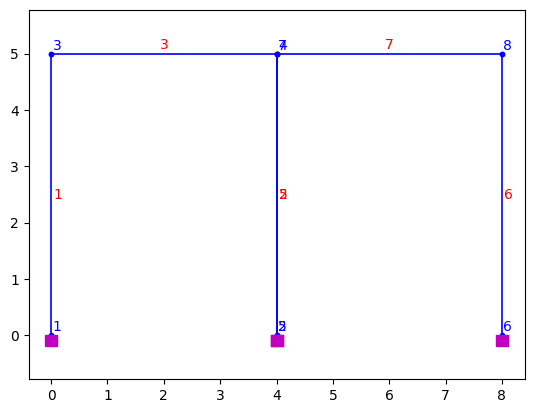

In [13]:
ovs.plot_model()

In [14]:
#kelvin voigt model
ops.node(9,bay,h1)
viscousID = 2
alpha = 1
ops.uniaxialMaterial('Viscous', viscousID, c2, alpha)
springID = 3
E0 = k2
ops.uniaxialMaterial('Elastic', springID, E0)
eppGAPMatID = 4
E = 2* E0
Fy = 250*10**6
ops.uniaxialMaterial('ElasticPPGap', eppGAPMatID, 1*E, -1*Fy, -1*gap, 0.1)
parallelTag = 100
ops.uniaxialMaterial('Parallel', parallelTag, *[viscousID, springID])
ops.element('zeroLength', 101, *[4,9], '-mat', parallelTag, '-dir', *[1])
ops.element('twoNodeLink',102,*[9,7],'-mat',eppGAPMatID,'-dir',*[1])

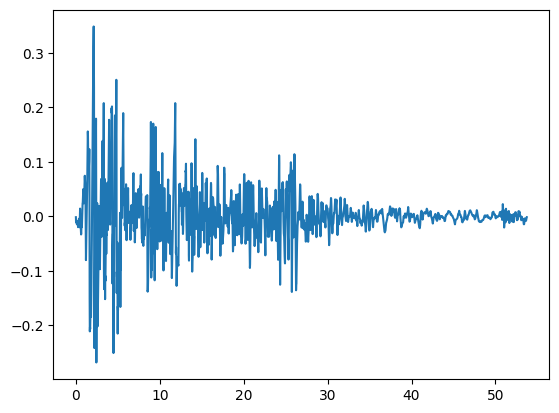

In [15]:
ground_motion = np.loadtxt('elcentro.txt',delimiter = " ")
plt.plot(ground_motion[:,0],ground_motion[:,1])
dt = ground_motion[:,0][1]

In [16]:
ops.timeSeries('Path', 1, '-dt', dt, '-values', *ground_motion[:,1], '-fact', 9.81)
ops.pattern('UniformExcitation', 200, 1, '-accel', 1)

In [17]:
#testing
ops.equalDOF(4,9,2,3)

In [23]:
eqLoad = 2
# ops.timeSeries('Path', eqLoad, '-dt', 0.01, '-filePath', "TakY.th", '-factor', g)
# ops.pattern('UniformExcitation', eqLoad, 1, '-accel', eqLoad)
# recorders

ops.recorder('Node', '-file', 'SDOF/left_corner_disp.txt', '-time', '-closeOnWrite','-node',4 , '-dof', 1, 'disp')
ops.recorder('Node', '-file', 'SDOF/right_corner_disp.txt', '-time', '-closeOnWrite','-node',7 , '-dof', 1, 'disp')
ops.recorder('Node', '-file', 'SDOF/left_corner_vel.txt', '-time', '-closeOnWrite','-node',4 , '-dof', 1, 'vel')
ops.recorder('Node', '-file', 'SDOF/right_corner_vel.txt', '-time', '-closeOnWrite','-node',7 , '-dof', 1, 'vel')
#ops.recorder('Element', '-file', 'eppDisplacement.txt', '-time', '-closeOnWrite','-ele',1 , '-dof', 1, 'deformation')
ops.recorder('Element', '-file', 'SDOF/Reactions_EPP.txt', '-time', '-closeOnWrite','-ele',101 , '-dof', 1, 'force')
ops.recorder('Element', '-file', 'SDOF/Reactions_KV.txt', '-time', '-closeOnWrite','-ele',102 , '-dof', 1, 'force')


# analysis
ops.constraints("Transformation")
ops.numberer("Plain")
ops.system("ProfileSPD")
tol = 1.e-8
maxNumIter = 50
ops.test("EnergyIncr", tol, maxNumIter)
ops.algorithm("ModifiedNewton")
ops.integrator("Newmark", .5, .25)
ops.analysis("Transient")

TmaxAnalysis = 10
DtAnalysis = 0.02

Nstep = int(TmaxAnalysis/DtAnalysis)

for i in range(Nstep):
    status = ops.analyze(1, DtAnalysis)
    # ovs.plot_defo()
    # plt.savefig(f'test_images/{(i+1)*DtAnalysis}s_{TmaxAnalysis}.png')
    # plt.close()
    print(f"Ground Motion - {i+1}/{Nstep}")
    if status != 0:
        print("Analysis failed trying Krylov Newton...")
        ops.algorithm('KrylovNewton')
        status = ops.analyze(1, DtAnalysis)
    if status != 0:
        print("Analysis failed trying with more iterations and less tolerance...")
        tol = 1.e-6
        maxNumIter = 100
        ops.system("BandSPD")
        ops.test("RelativeNormDispIncr", tol, maxNumIter)
        status = ops.analyze(1, DtAnalysis)
    if status!=0:
        print("Analysis failed trying Bryoden Algorithm")
        tol = 1.e-8
        maxNumIter = 50
        ops.test("EnergyIncr", tol, maxNumIter)
        ops.algorithm('Broyden')
        status = ops.integrator("HHT", 0.85, .5, .25)
        status = ops.analyze(1, DtAnalysis)
        #
    if status != 0:
        print("Breaking analysis")
        break
    
    ops.algorithm('ModifiedNewton')
    ops.system("ProfileSPD")
    tol = 1.e-10
    maxNumIter = 50    
    ops.test("EnergyIncr", tol, maxNumIter)
 

WARNING can't set handler after analysis is created


Ground Motion - 1/500
Ground Motion - 2/500
Ground Motion - 3/500
Ground Motion - 4/500
Ground Motion - 5/500
Ground Motion - 6/500
Ground Motion - 7/500
Ground Motion - 8/500
Ground Motion - 9/500
Ground Motion - 10/500
Ground Motion - 11/500
Ground Motion - 12/500
Ground Motion - 13/500
Ground Motion - 14/500
Ground Motion - 15/500
Ground Motion - 16/500
Ground Motion - 17/500
Ground Motion - 18/500
Ground Motion - 19/500
Ground Motion - 20/500
Ground Motion - 21/500
Ground Motion - 22/500
Ground Motion - 23/500
Ground Motion - 24/500
Ground Motion - 25/500
Ground Motion - 26/500
Ground Motion - 27/500
Ground Motion - 28/500
Ground Motion - 29/500
Ground Motion - 30/500
Ground Motion - 31/500
Ground Motion - 32/500
Ground Motion - 33/500
Ground Motion - 34/500
Ground Motion - 35/500
Ground Motion - 36/500
Ground Motion - 37/500
Ground Motion - 38/500
Ground Motion - 39/500
Ground Motion - 40/500
Ground Motion - 41/500
Ground Motion - 42/500
Ground Motion - 43/500
Ground Motion - 44/5

after: 50 iterations
 current EnergyIncr: 596.908 (max: 1e-10) 	Norm deltaX: 0.00210335, Norm deltaR: 1.10942e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.06
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 2.74649e-07 (max: 1e-10) 	Norm deltaX: 1.99672e-08, Norm deltaR: 53.7727
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.1
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 9479.08 (max: 1e-10) 	Norm deltaX: 0.00838187, Norm deltaR: 4.42107e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 3
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 2.44921

Ground Motion - 105/500
Analysis failed trying Krylov Newton...
Ground Motion - 106/500
Ground Motion - 107/500
Ground Motion - 108/500
Ground Motion - 109/500
Ground Motion - 110/500
Ground Motion - 111/500
Ground Motion - 112/500
Ground Motion - 113/500
Ground Motion - 114/500
Ground Motion - 115/500
Ground Motion - 116/500
Ground Motion - 117/500
Ground Motion - 118/500
Ground Motion - 119/500
Ground Motion - 120/500
Ground Motion - 121/500
Ground Motion - 122/500
Ground Motion - 123/500
Ground Motion - 124/500
Ground Motion - 125/500
Ground Motion - 126/500
Ground Motion - 127/500
Ground Motion - 128/500
Ground Motion - 129/500
Ground Motion - 130/500
Ground Motion - 131/500
Ground Motion - 132/500
Ground Motion - 133/500
Ground Motion - 134/500
Ground Motion - 135/500
Ground Motion - 136/500
Ground Motion - 137/500
Ground Motion - 138/500
Ground Motion - 139/500
Ground Motion - 140/500
Ground Motion - 141/500
Ground Motion - 142/500
Ground Motion - 143/500
Ground Motion - 144/500


after: 50 iterations
 current EnergyIncr: 950.679 (max: 1e-10) 	Norm deltaX: 0.00265445, Norm deltaR: 1.40011e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 4.12
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 9.7578e-08 (max: 1e-10) 	Norm deltaX: 1.19016e-08, Norm deltaR: 32.0515
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 4.16
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 2608.43 (max: 1e-10) 	Norm deltaX: 0.00439691, Norm deltaR: 2.31917e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.24
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 3.63

Ground Motion - 248/500
Ground Motion - 249/500
Ground Motion - 250/500
Ground Motion - 251/500
Ground Motion - 252/500
Ground Motion - 253/500
Ground Motion - 254/500
Ground Motion - 255/500
Ground Motion - 256/500
Ground Motion - 257/500
Ground Motion - 258/500
Ground Motion - 259/500
Ground Motion - 260/500
Ground Motion - 261/500
Ground Motion - 262/500
Analysis failed trying Krylov Newton...
Ground Motion - 263/500
Ground Motion - 264/500
Analysis failed trying Krylov Newton...
Ground Motion - 265/500
Ground Motion - 266/500
Ground Motion - 267/500
Ground Motion - 268/500
Ground Motion - 269/500
Ground Motion - 270/500
Ground Motion - 271/500
Ground Motion - 272/500
Ground Motion - 273/500
Ground Motion - 274/500
Ground Motion - 275/500
Ground Motion - 276/500
Ground Motion - 277/500
Ground Motion - 278/500
Ground Motion - 279/500
Ground Motion - 280/500
Ground Motion - 281/500
Ground Motion - 282/500
Ground Motion - 283/500
Ground Motion - 284/500
Ground Motion - 285/500
Ground M

after: 50 iterations
 current EnergyIncr: 159.364 (max: 1e-10) 	Norm deltaX: 0.00108681, Norm deltaR: 573244
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 6.44
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 3.67521e-07 (max: 1e-10) 	Norm deltaX: 2.30978e-08, Norm deltaR: 62.2034
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 6.48
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 2558.16 (max: 1e-10) 	Norm deltaX: 0.00435433, Norm deltaR: 2.29672e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 7.58
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 1.62252e

Ground Motion - 337/500
Ground Motion - 338/500
Ground Motion - 339/500
Ground Motion - 340/500
Ground Motion - 341/500
Ground Motion - 342/500
Ground Motion - 343/500
Ground Motion - 344/500
Ground Motion - 345/500
Ground Motion - 346/500
Ground Motion - 347/500
Ground Motion - 348/500
Ground Motion - 349/500
Ground Motion - 350/500
Ground Motion - 351/500
Ground Motion - 352/500
Ground Motion - 353/500
Ground Motion - 354/500
Ground Motion - 355/500
Ground Motion - 356/500
Ground Motion - 357/500
Ground Motion - 358/500
Ground Motion - 359/500
Ground Motion - 360/500
Ground Motion - 361/500
Ground Motion - 362/500
Ground Motion - 363/500
Ground Motion - 364/500
Ground Motion - 365/500
Ground Motion - 366/500
Ground Motion - 367/500
Ground Motion - 368/500
Ground Motion - 369/500
Ground Motion - 370/500
Ground Motion - 371/500
Ground Motion - 372/500
Ground Motion - 373/500
Ground Motion - 374/500
Ground Motion - 375/500
Ground Motion - 376/500
Ground Motion - 377/500
Ground Motion - 

after: 50 iterations
 current EnergyIncr: 1270.31 (max: 1e-10) 	Norm deltaX: 0.00306841, Norm deltaR: 1.61845e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 8.72
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 7.97917e-08 (max: 1e-10) 	Norm deltaX: 1.07624e-08, Norm deltaR: 28.9836
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 8.76
OpenSees > analyze failed, returned: -3 error flag


Ground Motion - 472/500
Ground Motion - 473/500
Ground Motion - 474/500
Ground Motion - 475/500
Ground Motion - 476/500
Ground Motion - 477/500
Ground Motion - 478/500
Ground Motion - 479/500
Ground Motion - 480/500
Ground Motion - 481/500
Ground Motion - 482/500
Ground Motion - 483/500
Ground Motion - 484/500
Ground Motion - 485/500
Ground Motion - 486/500
Ground Motion - 487/500
Ground Motion - 488/500
Ground Motion - 489/500
Ground Motion - 490/500
Ground Motion - 491/500
Ground Motion - 492/500
Ground Motion - 493/500
Ground Motion - 494/500
Ground Motion - 495/500
Ground Motion - 496/500
Ground Motion - 497/500
Ground Motion - 498/500
Ground Motion - 499/500
Ground Motion - 500/500


In [24]:
left_node_disp=np.loadtxt('SDOF/left_corner_disp.txt',delimiter = " ")
right_node_disp=np.loadtxt('SDOF/right_corner_disp.txt',delimiter = " ")

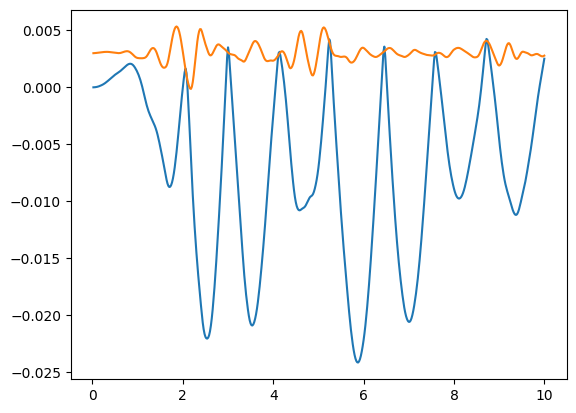

In [25]:
right_node_collided = right_node_disp[:,1] + gap
time = left_node_disp[:,0]
plt.plot(left_node_disp[:,0],left_node_disp[:,1])
plt.plot(right_node_disp[:,0],right_node_collided)


([<matplotlib.axis.YTick at 0x200023dfbd0>,
 [Text(0, 0.0, '0'),
  Text(0, 1000000.0, '1'),
  Text(0, 2000000.0, '2'),
  Text(0, 3000000.0, '3'),
  Text(0, 4000000.0, '4'),
  Text(0, 5000000.0, '5'),
  Text(0, 6000000.0, '6')])

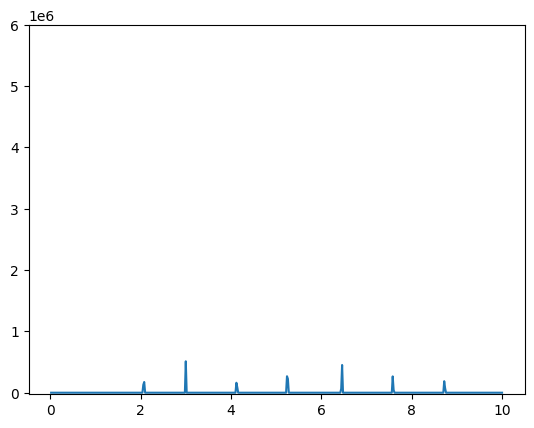

In [30]:
data1=np.loadtxt('SDOF/Reactions_EPP.txt',delimiter = " ")
data2=np.loadtxt('SDOF/Reactions_KV.txt',delimiter = " ")


plt.plot(data1[:,0],data1[:,1])
plt.yticks(np.arange(0,7e6, 1e6))


#axis[2].plot(data2[:,0],data2[:,1])

In [27]:
left_node_vel=np.loadtxt('SDOF/left_corner_vel.txt',delimiter = " ")
right_node_vel=np.loadtxt('SDOF/right_corner_vel.txt',delimiter = " ")

In [28]:
# left_node_disp, right_node_disp
force = np.zeros_like(left_node_disp[:, 1])
force = k2 * (left_node_disp[:,1] - right_node_disp[:,1]) + c2 *(left_node_vel[:,1] - right_node_vel[:,1])
collision = left_node_disp[:,1] - right_node_disp[:,1]
iscollided = collision >= 0
force[~iscollided] = 0

TypeError: float() argument must be a string or a real number, not 'Line2D'

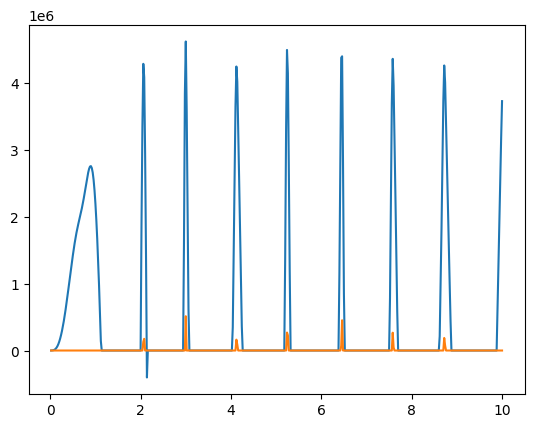

In [31]:
plt.plot(time, force)
plt.plot(plt.plot(data1[:,0],data1[:,1]))